Epoch 1/5 | G: 1.994 D_A: 0.077 D_B: 0.074
Epoch 2/5 | G: 2.211 D_A: 0.043 D_B: 0.037
Epoch 3/5 | G: 2.103 D_A: 0.038 D_B: 0.036
Epoch 4/5 | G: 2.179 D_A: 0.049 D_B: 0.052
Epoch 5/5 | G: 2.017 D_A: 0.035 D_B: 0.037


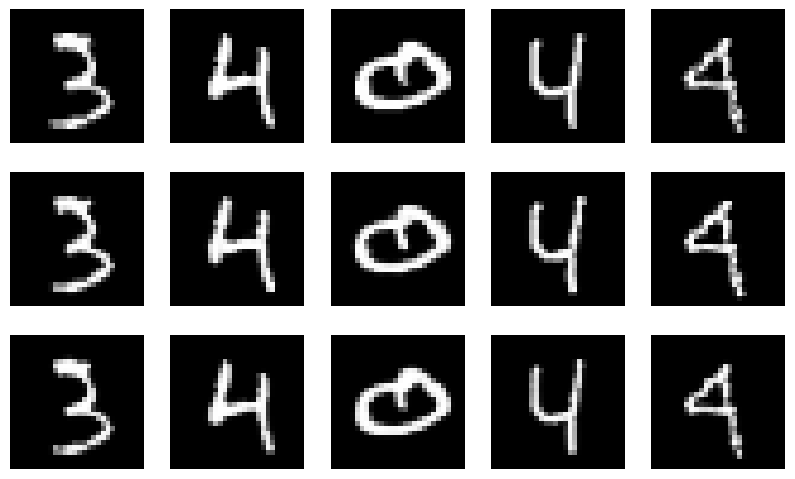

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


(x_train, y_train), (_, _) = keras.datasets.mnist.load_data()

# Normalize to [-1,1]
x_train = (x_train.astype("float32") - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)  # shape: (N,28,28,1)

# Domain A = digits 0-4, Domain B = digits 5-9
domainA = x_train[y_train <= 4]
domainB = x_train[y_train >= 5]

BUFFER_SIZE = 10000
BATCH_SIZE = 64

trainA = tf.data.Dataset.from_tensor_slices(domainA).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
trainB = tf.data.Dataset.from_tensor_slices(domainB).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)



def build_generator():
    inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(64, 3, padding="same")(inputs)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128, 3, padding="same")(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(1, 3, padding="same", activation="tanh")(x)
    return keras.Model(inputs, x)


def build_discriminator():
    inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(64, 3, strides=2, padding="same")(inputs)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)
    return keras.Model(inputs, x)

# Generators
G_AB = build_generator()  # A -> B
G_BA = build_generator()  # B -> A

# Discriminators
D_A = build_discriminator()  # real/fake A
D_B = build_discriminator()  # real/fake B


loss_obj = keras.losses.MeanSquaredError()

LAMBDA_CYCLE = 10.0

optimizer_G = keras.optimizers.Adam(2e-4, beta_1=0.5)
optimizer_D_A = keras.optimizers.Adam(2e-4, beta_1=0.5)
optimizer_D_B = keras.optimizers.Adam(2e-4, beta_1=0.5)


def discriminator_loss(real, fake):
    real_loss = loss_obj(tf.ones_like(real), real)
    fake_loss = loss_obj(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


def generator_loss(fake):
    return loss_obj(tf.ones_like(fake), fake)


def cycle_loss(real, cycled):
    return LAMBDA_CYCLE * tf.reduce_mean(tf.abs(real - cycled))


@tf.function
def train_step(real_A, real_B):
    with tf.GradientTape(persistent=True) as tape:
        # A -> B -> A
        fake_B = G_AB(real_A, training=True)
        cycled_A = G_BA(fake_B, training=True)

        # B -> A -> B
        fake_A = G_BA(real_B, training=True)
        cycled_B = G_AB(fake_A, training=True)

        # Discriminator predictions
        disc_real_A = D_A(real_A, training=True)
        disc_real_B = D_B(real_B, training=True)
        disc_fake_A = D_A(fake_A, training=True)
        disc_fake_B = D_B(fake_B, training=True)

        # Generator losses
        loss_G_AB = generator_loss(disc_fake_B)
        loss_G_BA = generator_loss(disc_fake_A)
        total_cycle_loss = cycle_loss(real_A, cycled_A) + cycle_loss(real_B, cycled_B)
        total_G_loss = loss_G_AB + loss_G_BA + total_cycle_loss

        # Discriminator losses
        loss_D_A = discriminator_loss(disc_real_A, disc_fake_A)
        loss_D_B = discriminator_loss(disc_real_B, disc_fake_B)

    # Apply gradients
    grads_G = tape.gradient(total_G_loss, G_AB.trainable_variables + G_BA.trainable_variables)
    optimizer_G.apply_gradients(zip(grads_G, G_AB.trainable_variables + G_BA.trainable_variables))

    grads_D_A = tape.gradient(loss_D_A, D_A.trainable_variables)
    optimizer_D_A.apply_gradients(zip(grads_D_A, D_A.trainable_variables))

    grads_D_B = tape.gradient(loss_D_B, D_B.trainable_variables)
    optimizer_D_B.apply_gradients(zip(grads_D_B, D_B.trainable_variables))

    return total_G_loss, loss_D_A, loss_D_B


EPOCHS = 5
for epoch in range(EPOCHS):
    for real_A, real_B in tf.data.Dataset.zip((trainA, trainB)):
        g_loss, dA_loss, dB_loss = train_step(real_A, real_B)
    print(f"Epoch {epoch+1}/{EPOCHS} | G: {g_loss:.3f} D_A: {dA_loss:.3f} D_B: {dB_loss:.3f}")


def show_samples():
    real_A = next(iter(trainA))[:5]
    fake_B = G_AB(real_A, training=False)
    cycled_A = G_BA(fake_B, training=False)

    fig, axes = plt.subplots(3, 5, figsize=(10,6))
    for i in range(5):
        axes[0,i].imshow(real_A[i,:,:,0]*0.5+0.5, cmap="gray")
        axes[0,i].axis("off")
        axes[1,i].imshow(fake_B[i,:,:,0]*0.5+0.5, cmap="gray")
        axes[1,i].axis("off")
        axes[2,i].imshow(cycled_A[i,:,:,0]*0.5+0.5, cmap="gray")
        axes[2,i].axis("off")
    plt.show()

show_samples()
